To view the notebook as a presentation press the icon that looks like a small histogram.

This notebook is hosted at: https://github.com/mj-will/nessai-rise-presentation

Copyright (C) Michael J. Williams (2021)

# nessai: Improved nested sampling with normalising flows

**Michael J. Williams, John Veitch, Chris Messenger**

**Institute for Gravitational Research, University of Glasgow**

In [1]:
import matplotlib.pyplot as plt
import nessai
import seaborn as sns

sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('colorblind')
plt.rcParams['figure.dpi'] = 150

# Nested sampling

### Bayes theorem

We want to determine the posterior distribution

$$
p(\theta|d, H) = \frac{p(d|\theta, H)p(\theta|H)}{p(d|H)}
$$

but we can do this directly. So we typically use Monte Carlo based algorithms.

### Nested sampling

In nested sampling the evidence is re-written as 1-d integral in terms of the **prior volume** $X$

$$
Z = \int_{0}^{1}L(X) dX.
$$

<center><img src="figures/nest_plot.png" width="100%"></center>

Prevent split slides from merging on to one.

**Challenges with nested sampling**

1. New point must be drawn from the prior
2. The must satisfy the likelihood constraint
3. They must be statistically independent of the other/previous points

Proposing new points is therefore usually a significant bottleneck.

<center><img src="figures/nest_plot.png" width="100%"></center>

# nessai: NeSted Sampling with Aritificial Intelligence

# Core idea

Train a machine learning algorithm to learn iso-likelihood contours during nested sampling and then sample directly from those contours to produce new samples according to the prior.

<center><img src='figures/contours_idea.png'></center>


# Normalising flows

Normalising flows a type of generative machine learning algorithm that learn an invertible mapping from a complex distribution to a simple distribution.

<center><img src='figures/flow_steps.png' width="200%"></center>

The mapping has a tractable Jacobian so we can compute the probability of a sample in the physical space:

$$
p_{X}(x) = p_{Z}(f(x)) \left| \frac{\partial f(x)}{\partial x}\right|,
$$

where $f$ is the normalising flow.

# Constructing contours

We use the fact that the latent space is Gaussian and the mapping it invertible to construct contours in the latent space and map them back to the sampling space.

<center><img src='figures/contours_idea_latent.png'></center>

# Core algorithm

<center><img src="figures/nessai_cycle.png"></center>

`nessai` can be broken down in three steps:

1. **Training** - the normalising flow is trained using the current set of live points

2. **Population** - new points are drawn from the trained flow and their likelihoods evaluated and they're stored in a pool

3. **Proposal** - the main nested sampling step when new points are proposed and accepted if they meet the likelihood criterion


# Validating nessai

## Testing with CBC signals

`nessai` is a general purpose nested sampling algorithm, but a lot our testing has focused on analysing gravitational waves from Compact Binary Coalescence (CBC).

In our first paper on `nessai` we showed that it could reliably recover posterior distributions for simulated signals from binary black holes.

We analysed 128 4-second injections in a three detector network with a median SNR of 16.3.

<center><img src='figures/snr_dist.png' width="50%"></center>

## PP tests

<center><img src='./figures/pp_plot_nessai.png'></center>

# Comparison to dynesty

<center><img src='./figures/comparison.png'></center>

# Parallelisation with nessai

In `nessai` new points are drawn in batches of typically a few thousand. This provides a natural point at which to parallelise the likelihood.

For example, for a CBC case this can significantly reduce sampling time.

<center><img src='figures/paralellisation.png'></center>

# Using nessai

# Using nessai

`nessai` can be used independently or via `bilby`. Here I'll show you how to set up a run using `nessai` in `bilby`.

### Installation

`nessai` is included in bilby but is not installed by default. It can be installed using `pip`:

```bash
$ pip install nessai
```

though it depends on `PyTorch` so it is strongly recommended to install first following the instructions [here](https://pytorch.org/).

This example is based on the linear regression example from `bilby`.

In [2]:
import bilby
import numpy as np
# Set this so we can re-run this example multiple times
bilby.utils.command_line_args.clean = True

# Setting up a model

We're going to use a simple linear function for the model:

$$
f(t) = mt + c
$$

In [3]:
def model(time, m, c):
    """Basic linear model."""
    return time * m + c

# Generate the data
injection_parameters = dict(m=1.3, c=-1.7)
sampling_frequency = 10
time_duration = 10
time = np.arange(0, time_duration, 1 / sampling_frequency)
N = len(time)
sigma = np.random.normal(1, 0.01, N)
data = model(time, **injection_parameters) + np.random.normal(0, sigma, N)

# Define the likelihood
likelihood = bilby.likelihood.GaussianLikelihood(time, data, model, sigma)

# Define priors on m and c
priors = dict()
priors['m'] = bilby.core.prior.Uniform(0, 5, 'm')
priors['c'] = bilby.core.prior.Uniform(-2, 2, 'c')

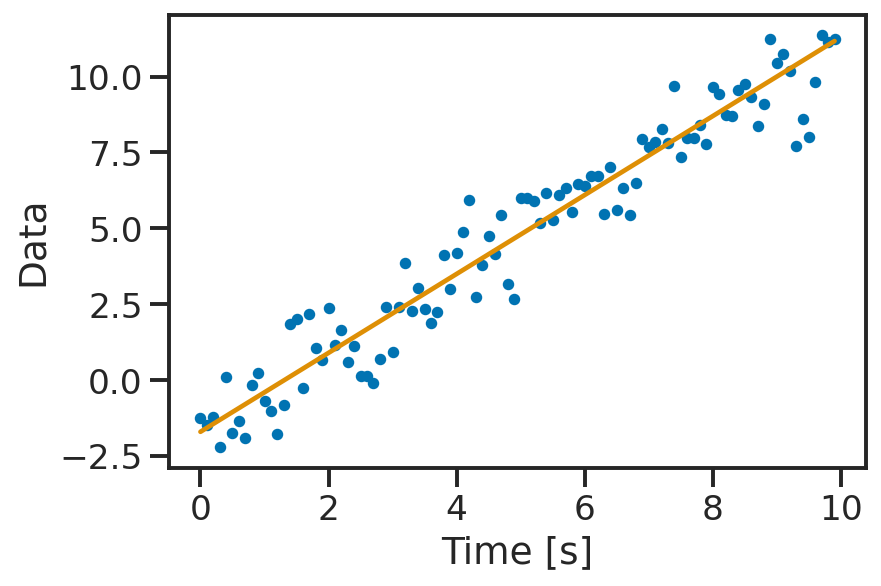

In [4]:
plt.plot(time, data, '.')
plt.plot(time, model(time, **injection_parameters))
plt.xlabel('Time [s]')
plt.ylabel('Data')
plt.show()

# Running nessai using bilby

Just like any other sampler you configure `nessai` by passing arguments to `run_sampler`

Need to do the usual configuration for `bilby`. This includes setting up the output directory and the logger. We've used the `WARNING` level to make the output more compact, but `bilby` normally uses `INFO` by default.

In [5]:
label = "example"
outdir = "outdir"
bilby.utils.setup_logger(outdir=outdir, label=label, log_level='WARNING')

In [6]:
# We disable checkpointing for this example
result = bilby.run_sampler(
    likelihood=likelihood, priors=priors, outdir=outdir, label=label,
    sampler="nessai", nlive=1000, plot=True, resume=False, checkpointing=False,  
    injection_parameters=injection_parameters, seed=150914,
)

11:29 bilby WARNING : Setting pool to None (n_pool=1 & max_threads=1)
12-13 11:29 nessai.nestedsampler WARNING : Proposal will only train when empty
12-13 11:29 nessai.proposal.flowproposal WARNING : Extra kwargs were parsed to FlowProposal: {'augment_dims': 1, 'generate_augment': 'gaussian', 'marginalise_augment': False, 'n_marg': 50}
Drawing live points: 100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 18796.40it/s]
12-13 11:29 nessai.nestedsampler CRITICAL: Starting nested sampling loop
12-13 11:29 nessai.nestedsampler WARNING : it:  1000: n eval: 2764 H: 7.09 dZ: 1384.315 logZ: -1524.996 +/- 0.084 logLmax: -139.68
12-13 11:29 nessai.nestedsampler WARNING : Rolling KS test: D=0.018, p-value=0.5169
12-13 11:29 nessai.nestedsampler WARNING : it:  2000: n eval: 7331 H: 6.94 dZ: 239.942 logZ: -381.478 +/- 0.083 logLmax: -139.54
12-13 11:29 nessai.nestedsampler WARNING : Rolling KS test: D=0.018, p-value=0.5169
12-13 11:30 nessai.n

# Parallelisation

Parallelisation is simple, we set a maximum number of threads (`max_threads`) and a number threads to use for the likelihood (`n_pool`).

The benefit is minimal in this example because the likelihood is quick to evaluate and the problem is simple.

In [7]:
# We disable checkpointing for this example
result = bilby.run_sampler(
    likelihood=likelihood, priors=priors, outdir=outdir, label=label,
    sampler="nessai", nlive=1000, plot=True, resume=False, checkpointing=False,  
    injection_parameters=injection_parameters, seed=150914,
    max_threads=3, n_pool=2,
)

11:30 bilby WARNING : Supplied argument 'npool' not an argument of 'Nessai', removing.
12-13 11:30 nessai.nestedsampler WARNING : Proposal will only train when empty
12-13 11:30 nessai.proposal.flowproposal WARNING : Extra kwargs were parsed to FlowProposal: {'augment_dims': 1, 'generate_augment': 'gaussian', 'marginalise_augment': False, 'n_marg': 50}
Drawing live points: 100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 29488.76it/s]
12-13 11:30 nessai.nestedsampler CRITICAL: Starting nested sampling loop
12-13 11:30 nessai.nestedsampler WARNING : it:  1000: n eval: 3000 H: 7.09 dZ: 1384.315 logZ: -1524.996 +/- 0.084 logLmax: -139.68
12-13 11:30 nessai.nestedsampler WARNING : Rolling KS test: D=0.018, p-value=0.5169
12-13 11:30 nessai.nestedsampler WARNING : it:  2000: n eval: 8000 H: 6.94 dZ: 239.942 logZ: -381.478 +/- 0.083 logLmax: -139.54
12-13 11:30 nessai.nestedsampler WARNING : Rolling KS test: D=0.018, p-value=0.5169
12-

# Results

The standard `bilby` results will be produced, but `nessai` also produces some specific results in `_nessai` directory.


The images are included via Markdown using the files generated by the sampler, because of this they won't automatically update if the files are changed.

## Posterior distribution

<center><img src="outdir/example_corner.png" style="display:block; margin:auto"></center>


## Nessai specific outputs

These includes details about the exact configuration used, a results file with additional information and additional plots. These all can be helpful when examining runs.

In [8]:
!ls outdir/example_nessai/

config.json	       nested_sampler_resume.pkl      result.json
diagnostics	       nested_sampler_resume.pkl.old  state.png
insertion_indices.png  posterior_distribution.png     trace.png
logXlogL.png	       proposal


## Diagnosing a run

`nessai` includes various diagnostic plots that can help diagnose runs. These can help you identify problems during sampling and under- or over-constrained results.

## Trace plot

<center><img src='outdir/example_nessai/trace.png'></center>

## Indices plot

Fowlie et al showed that a cross-check based on order statistics can detect problems during sampling. The check is backed on the observation that insertion indexes of new live points into the existing live points should be uniformly distributed.

<center><img src='outdir/example_nessai/insertion_indices.png'></center>

See [arXiv:2006.03371](https://arxiv.org/abs/2006.03371) for more details


## State plot

<center><img src='outdir/example_nessai/state.png'></center>

# A word of caution

Whilst normalising flows can learn complex distributions, there are some limitations, for example they struggle with angles and periodicity.

Thankfully we can address this by reparameterising the sampling space to something that is better suited to flows.

For example, say our likelihood included an angle $\theta$ that is periodic on $[0, 2\pi]$. We can configure `nessai` based on this information by adding a reparameterisation:

```python
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler="nessai",
    outdir=outdir,
    label=label,
    plot=True,
    injection_parameters=injection_parameters,
    reparameterisations={'theta': {'reparamerisation': 'angle-2pi'}},
)

```
This tells `nessai` to use the built-in reparameterisation for angles that are periodic on on $[0, 2 \pi]$. 

More details about the different reparameterisations can be found in the documentation [here](https://nessai.readthedocs.io/en/latest/reparameterisations.html).

# Summary

* `nessai` is nested sampling algorithm that incorporates normalising flows
* It can speed up inference when compared another commonly used sampler `dynesty`
* Parallelising the likelihood computation is simple in `nessai`
* It's available in `bilby` and ready for use

# For more details

* [Documentation](https://nessai.readthedocs.io/en/latest/?badge=latest)
* [Examples](https://github.com/mj-will/nessai/tree/main/examples)
* The nessai paper: [Nested Sampling with Normalising Flows for Gravitational-Wave Inference](https://arxiv.org/abs/2102.11056)

# Questions?

# Additional slides

# Applying nessai to GW inference

`nessai` includes a default configuration for gravitational-wave inference. This includes reparameterisations for common parameters. 

This requires an additional setting shown below

```python
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler="nessai",
    outdir=outdir,
    label=label,
    plot=True,
    injection_parameters=injection_parameters,
    flow_class='gwflowproposal',
)

```